<a href="https://colab.research.google.com/github/masterinfo/COURS_ELEARNING/blob/master/LLM_tutoriel_wilfrid_morel_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build your own Large Language Model (LLM) From Scratch Using PyTorch

tutoriel pour comprendre les LLM classes de Masteres inspiré de
 https://pub.towardsai.net/build-your-own-large-language-model-llm-from-scratch-using-pytorch-9e9945c24858

Installation des livrairies

In [ ]:
!pip install datasets tokenizers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.6 MB/s eta 0:00:00


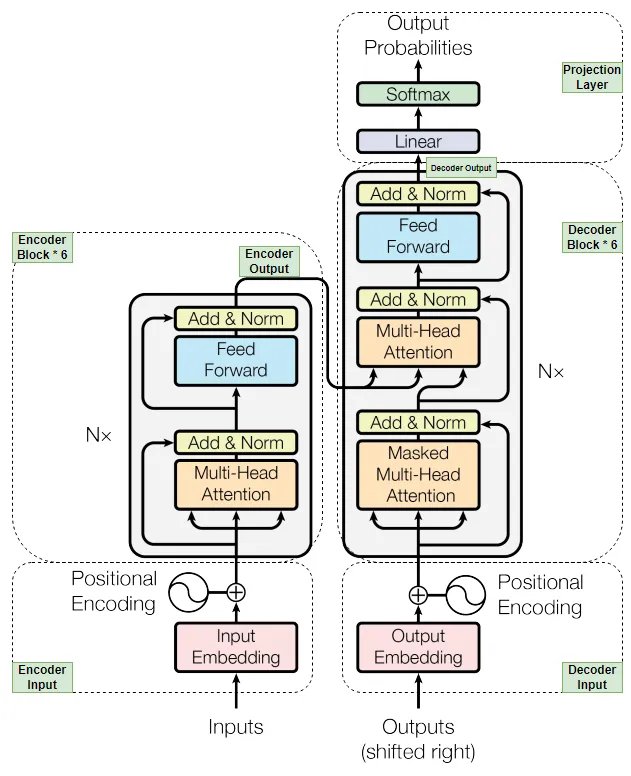

Ce schéma représente l'architecture du modèle Transformer, un composant fondamental de nombreux modèles de traitement du langage naturel modernes, y compris les Large Language Models (LLMs). Il est composé de deux parties principales : l'encodeur (à gauche) et le décodeur (à droite).
*****************************Encoder******************************************
Input Embedding: La phrase d'entrée est transformée en embeddings, c'est-à-dire des vecteurs qui représentent chaque mot de la phrase dans un espace multidimensionnel.

Positional Embedding :Puisqu'un Transformer ne possède pas intrinsèquement d'informations sur l'ordre des mots, un encodage positionnel est ajouté aux embeddings pour coder la position de chaque mot dans la phrase.

EncoderBlock * N :L'encodeur est composé de plusieurs blocs identiques (ici, N=6). Chaque bloc comprend :

=>Multihead Attention: Ce mécanisme permet au modèle de considérer simultanément différentes parties de la phrase d'entrée et de capturer les relations entre les mots.

=>Add & Norm: Il s'agit d'une étape d'addition (ajout de la connexion résiduelle, qui aide à entraîner des réseaux profonds) et de normalisation (Layer Normalization, qui stabilise l'apprentissage).

==>Feed Forward: Un réseau de neurones à propagation avant qui traite chaque position individuellement.

Encoder Output: La sortie de l'encodeur représente une version transformée et enrichie de la phrase d'entrée.

****************************Decoder *************************************

Output Embedding: Similaire à l'encodeur, la séquence de sortie (décalée d'une position vers la droite, car le modèle prédit le prochain mot) est transformée en embeddings.

Positionnal encoding: Un encodage positionnel est ajouté pour coder la position des mots dans la séquence de sortie.

Decoder block *N: Le décodeur est également composé de plusieurs blocs identiques (ici, N=6). Chaque bloc comprend :

=>Masked Multi head attention: Identique au Multi-Head Attention de l'encodeur, mais avec un masque pour empêcher le modèle de "voir" le futur (c'est-à-dire les mots suivants dans la séquence de sortie) lors de la prédiction du mot courant.

=>Add & norm: Addition et normalisation, comme dans l'encodeur.

=>Multi head attention: Ce mécanisme permet au décodeur de prendre en compte à la fois la sortie du bloc d'encodeur et les mots déjà générés dans la séquence de sortie.

=>Add & norm: Addition et normalisation, comme précédemment.

=>Feed Forward   : Un réseau de neurones à propagation avant qui traite chaque position individuellement.



Linear: Une couche linéaire qui projette la sortie du décodeur dans l'espace du vocabulaire.

Softmax: Une fonction Softmax qui convertit les sorties linéaires en probabilités, représentant la probabilité que chaque mot du vocabulaire soit le prochain mot dans la séquence de sortie.
**********************************************************

La sortie du décodeur est une distribution de probabilité sur le vocabulaire, indiquant la probabilité que chaque mot soit le prochain mot dans la séquence de sortie.

Ce modèle est souvent utilisé pour des tâches de traduction automatique, de résumé de texte, et de génération de texte, entre autres. L'encodeur traite la phrase d'entrée, et le décodeur génère la phrase de sortie en se basant sur la sortie de l'encodeur et les mots déjà générés.

Step 1: Load dataset Load the data and separate into train, validation and test data


In [ ]:

# Import necessary libraries
# Install datasets, tokenizers library if you've not done so yet (!pip install datasets, tokenizers).
import os
import math
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import   DataLoader, random_split
from pathlib import Path
from datasets import load_dataset
from tqdm import tqdm

repwil="/content/drive/My Drive/LLM"

os.mkdir(repwil+"/frgpt") if not os.path.exists(repwil+"/frgpt") else None
os.mkdir(repwil+"/tokenizer_en") if not os.path.exists(repwil+"/tokenizer_en") else None
os.mkdir(repwil+"/tokenizer_fr") if not os.path.exists(repwil+"/tokenizer_fr") else None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device


device(type='cuda')

Chargements des phrases en anglais et francais  /Fait partie d'une famille plus large de modèles OPUS-MT, qui couvrent de nombreuses paires de langues





In [ ]:
train_dataset = load_dataset("Helsinki-NLP/opus-100", "en-fr", split='train')
validation_dataset = load_dataset("Helsinki-NLP/opus-100", "en-fr", split='validation')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/327k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/334k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
longest_sentence = ""
i=0
imax=0
for example in tqdm(train_dataset):
    i+=1
    if len(example["translation"]["fr"]) > len(longest_sentence):
        longest_sentence = example["translation"]["fr"]
        imax=i

print("Longest French sentence:")
print(longest_sentence)
print(f"Length: {len(longest_sentence)}  avec i du max = {imax}")

100%|██████████| 1000000/1000000 [00:28<00:00, 35355.66it/s]

Longest French sentence:
État des contributions au 30 novembre 2002 Table des matières  Introduction  Le présent document est publié conformément à la décision prise par l'Assemblée générale à sa 2444e séance plénière, le 17 décembre 1975, aux termes de laquelle le Secrétaire général doit indiquer aux États Membres, chaque semestre, pour chaque État Membre, le montant de la quote-part, le montant acquitté et le montant restant dû au titre du budget ordinaire et des opérations de caractère continu faisant l'objet d'une contribution spéciale.  Cette décision était motivée, entre autres, par l'appel du Secrétaire général demandant aux États Membres d'améliorer la situation de trésorerie de l'Organisation en acquittant plus rapidement leurs contributions.  La raison pour laquelle un état des contributions est publié maintenant est que l'Organisation continue de se heurter à des difficultés financières et que les États Membres ont demandé à être tenus informés de la situation.  Les paiement

In [ ]:
longest_sentence = ""
i=0
imax=0

for example in tqdm(train_dataset):
    i+=1
    if len(example["translation"]["en"]) > len(longest_sentence):
        longest_sentence = example["translation"]["fr"]
        imax=i
print("Longest FEnglish sentence:")
print(longest_sentence)
print(f"Length: {len(longest_sentence)} avec i du max = {imax}")

100%|██████████| 1000000/1000000 [00:29<00:00, 33613.11it/s]

Longest FEnglish sentence:
Application partly rejected - FR 25 CTMR.007(1)b Marque Verbale 03516283 15/11/2004 SILVER EDITION Application partly rejected - FR 14 CTMR.007(1)b,CTMR.007(1)c,CTMR.007(2) Marque Verbale 02743615 12/11/2004 THE GREATEST TURF ON EARTH Application rejected - FR 27,37 CTMR.007(1)b,CTMR.007(1)c Marque Verbale 03364973 12/11/2004 CAMIÑO DO MIÑO Application partly rejected - FR 41,43 CTMR.007(1)b,CTMR.007(1)c Marque Verbale 03453388 12/11/2004 FABULOSO Application rejected - FR 33 CTMR.007(1)b R0023/2005-4 Marque Verbale 03511029 12/11/2004 DIGI-OPTIC Application rejected - FR 09 CTMR.007(1)b,CTMR.007(1)c Marque Verbale 03600004 12/11/2004 Application rejected - FR 11 CTMR.007(1)b Figurative 03623857 12/11/2004 REVISTA CRITICA DE DERECHO INMOBILIARIO Application rejected - FR 09,16,41 CTMR.007(1)b,CTMR.007(1)c Marque Verbale 03676591 12/11/2004 TRAVELFUNDS Application rejected - FR 36 CTMR.007(1)b,CTMR.007(1)c Marque Verbale 03740404 12/11/2004 REVISTA HISPANO LUS

In [ ]:
train_dataset[:10]

{'translation': [{'en': 'The time now is 05:08 .',
   'fr': 'The time now is 05:05 .'},
  {'en': 'This Regulation shall enter into force on the seventh day following its publication in the Official Journal of the European Union.',
   'fr': "Le présent règlement entre en vigueur le septième jour suivant celui de sa publication au Journal officiel de l'Union européenne."},
  {'en': "Hello, what's that?", 'fr': "Qu'est-ce que c'est que ça ?"},
  {'en': 'And then I will teach you everything i know.',
   'fr': "Et alors, je t'apprendrai tout ce que je sais."},
  {'en': 'Did you find something?', 'fr': 'Par ici !'},
  {'en': 'Article 6', 'fr': 'Article 6'},
  {'en': "Oh, honey, it's not your fault.",
   'fr': "- Tu n'es pas responsable."},
  {'en': "I'm onto him now.", 'fr': 'Je le tiens.'},
  {'en': "DG XVI's Internet site (electronic address: http://www.cec.lu/en/comm/dg16/dg16home.html) now contains detailed information in English on pilot projects on innovation, the Information society, 

In [ ]:
# limit the number of data in dataset for faster training purpose
raw_train_dataset, rt_to_skip = random_split(train_dataset, [1500,len(train_dataset)-1500])#1500 en anglais francais pour entrainer au lieu de 100000
raw_validation_dataset, vt_to_skip = random_split(validation_dataset, [50,len(validation_dataset)-50])#1500 en anglais francais pour valider au lieu de 100000

In [ ]:
raw_train_dataset[:10]

{'translation': [{'en': 'He might stay. Why?',
   'fr': "- Il se peut qu'il reste."},
  {'en': 'May it work its lid in colours.',
   'fr': 'Tu peux utiliser la meule miraculeuse.'},
  {'en': "It's authentic.", 'fr': "C'est authentique."},
  {'en': "- What's going on?", 'fr': '- Alors ?'},
  {'en': 'It recommends that the State party provide statistical information on prosecutions launched, and penalties imposed, in cases of\xa0offences which relate to hate crimes and where the relevant provisions of the existing domestic legislation have been applied.',
   'fr': "Il recommande à l'État partie de fournir des données statistiques sur les poursuites engagées et les peines prononcées dans des cas où les\xa0infractions étaient liées à des crimes dictés par la haine et où les dispositions pertinentes de la législation nationale existante ont été appliquées."},
  {'en': '- Hold up!', 'fr': '- Attendez !'},
  {'en': 'Oh, God.', 'fr': 'Seigneur.'},
  {'en': 'Its flexibility, combined with the s

In [ ]:
raw_validation_dataset[:10 ]

{'translation': [{'en': "We've lost so many to them.",
   'fr': 'Nous avons tellement perdu pour eux.'},
  {'en': 'o by a non-resident entity (as defined in subsection 94.1(1)).',
   'fr': 'o par une entité non-résidente (définie au paragraphe 94.1(1)).'},
  {'en': 'The change is small compared to the changes over geological time, but the rate of change is high.',
   'fr': 'Ce changement est petit en comparaison de ceux qui ont eu lieu au cours des temps géologiques, mais il se produit rapidement.'},
  {'en': 'In particular, please indicate whether there is any legal provision criminalizing forced recruitment or involvement in hostilities of a person under the age of 18 by armed forces other than the Kuwaiti military.',
   'fr': "En\xa0particulier, indiquer s'il existe des dispositions juridiques réprimant l'enrôlement forcé par des forces armées autres que koweïtiennes de personnes de moins de 18\xa0ans ou leur participation à des hostilités."},
  {'en': 'Therefore, on the basis of th

In [ ]:
longest_sentence = ""
i=0
imax=0
for example in tqdm(raw_train_dataset):
    i+=1
    if len(example["translation"]["fr"]) > len(longest_sentence):
        longest_sentence = example["translation"]["fr"]
        imax=i

print("Longest French sentence ( in raw data  ):")
print(longest_sentence)
print(f"Length: {len(longest_sentence)}  avec i du max = {imax}")

100%|██████████| 1500/1500 [00:00<00:00, 17319.57it/s]

Longest French sentence ( in raw data  ):
Sous réserve de l'article 73, si les terres de remplacement trouvées par l'autorité expropriante fédérale entraîneraient une diminution de la superficie totale des Terres tsawwassen par rapport à leur superficie totale à la date d'entrée en vigueur et que la Première Nation de Tsawwassen n'accepte pas que les terres de remplacement sont de valeur comparable à celle de l'intérêt sur les Terres tsawwassen qui fait l'objet d'une expropriation, la Première Nation de Tsawwassen peut soumettre à un arbitrage définitif, effectué conformément au chapitre intitulé « Règlement des différends », la question de savoir si les terres de remplacement sont de valeur comparable à celle de l'intérêt exproprié.??71. La valeur totale de l'indemnité pour un intérêt sur les Terres tsawwassen qu'une autorité expropriante fédérale a exproprié en vertu du présent chapitre sera calculée en prenant compte des facteurs suivants : a. la valeur marchande de l'intérêt exprop

In [ ]:
longest_sentence = ""
i=0
imax=0

for example in tqdm(raw_train_dataset):
    i+=1
    if len(example["translation"]["en"]) > len(longest_sentence):
        longest_sentence = example["translation"]["en"]
        imax=i
print("Longest  English sentence: (in raw data)")
print(longest_sentence)
print(f"Length: {len(longest_sentence)} avec i du max = {imax}")

100%|██████████| 1500/1500 [00:00<00:00, 17638.15it/s]

Longest  English sentence: (in raw data)
The Plenary also agreed to review the duration of the Working Groups (one week) in the future, taking into account their workload and financial considerations; (b) to assist the participation of delegations from developing countries and certain countries in Europe and Asia, subject to the availability of financial resources of WIPO, WIPO should invite at the expense of WIPO those delegations to participate in both the Plenary and Working Groups; (c) the SCIT should not only deal with matters concerning the global information network, but also with other matters concerning information technologies useful to intellectual property offices; (d) that the adoption of the draft report by electronic communication after the meeting be tested for the first meeting of the Working Groups in November 1998; the Plenary requested the Secretariat to install the necessary facilities to achieve this and report the result of the trial to the second session of the 

In [ ]:
raw_train_dataset[810]

{'translation': {'en': 'The Plenary also agreed to review the duration of the Working Groups (one week) in the future, taking into account their workload and financial considerations; (b) to assist the participation of delegations from developing countries and certain countries in Europe and Asia, subject to the availability of financial resources of WIPO, WIPO should invite at the expense of WIPO those delegations to participate in both the Plenary and Working Groups; (c) the SCIT should not only deal with matters concerning the global information network, but also with other matters concerning information technologies useful to intellectual property offices; (d) that the adoption of the draft report by electronic communication after the meeting be tested for the first meeting of the Working Groups in November 1998; the Plenary requested the Secretariat to install the necessary facilities to achieve this and report the result of the trial to the second session of the Plenary to assess

In [ ]:
raw_train_dataset[810]['translation']['en']

'The Plenary also agreed to review the duration of the Working Groups (one week) in the future, taking into account their workload and financial considerations; (b) to assist the participation of delegations from developing countries and certain countries in Europe and Asia, subject to the availability of financial resources of WIPO, WIPO should invite at the expense of WIPO those delegations to participate in both the Plenary and Working Groups; (c) the SCIT should not only deal with matters concerning the global information network, but also with other matters concerning information technologies useful to intellectual property offices; (d) that the adoption of the draft report by electronic communication after the meeting be tested for the first meeting of the Working Groups in November 1998; the Plenary requested the Secretariat to install the necessary facilities to achieve this and report the result of the trial to the second session of the Plenary to assess it for further action 



---



In [ ]:
raw_train_dataset[810]['translation']['fr']

"Le SCIT plénier a aussi convenu d'examiner ultérieurement la question de la durée des réunions des groupes de travail (une semaine), compte tenu de la charge de travail de ces derniers et des incidences financières; b) pour favoriser la participation de délégations des pays en développement et de certains pays d'Europe et d'Asie, l'OMPI devra inviter à ses frais, dans la limite des ressources financières disponibles, ces pays à participer aux sessions du SCIT plénier et de ses groupes de travail; c) le SCIT s'occupera non seulement des questions relatives au réseau mondial d'information, mais aussi d'autres questions relatives aux techniques de l'information qui se révéleront pertinentes pour les offices de propriété intellectuelle; d) l'adoption du projet de rapport par communication électronique après la réunion sera expérimentée pour la première session des groupes de travail en novembre 1998; le SCIT plénier a demandé au Secrétariat de mettre en place les installations nécessaires

Step 2: Create Tokenizer

we’re going to use a popular tokenizer called BPE tokenizer which is a subword tokenizer that is being used in models like GPT3. We’ll first train the BPE tokenizer on the corpus data (training dataset in our case) which we’ve prepared in step 1. The flow goes like the diagram below.

The BPE tokenizer takes a raw text, maps it with the tokens in vocabulary, and returns a token for each word in the input raw text.

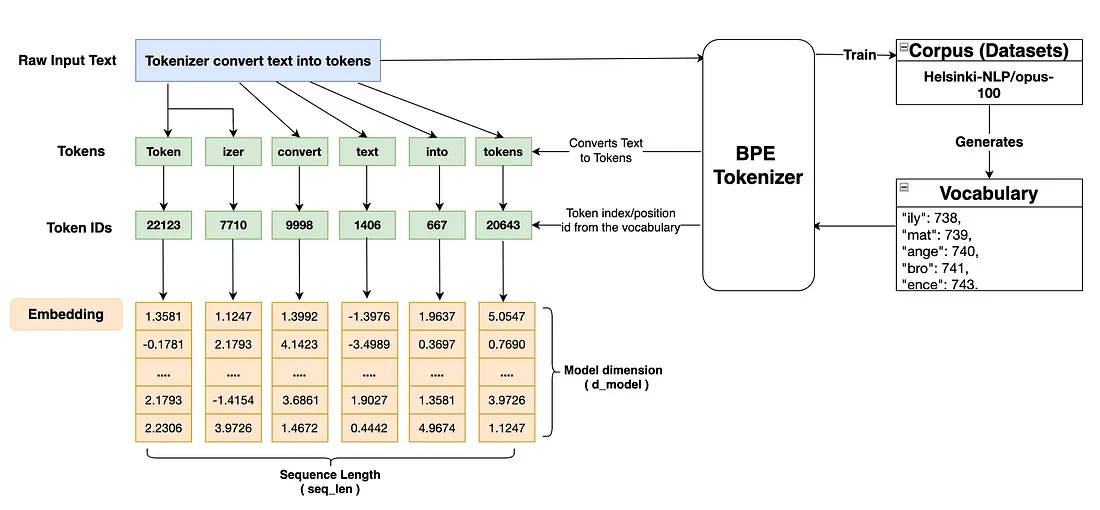Step 2: Create Tokenizer

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

def get_ds_iterator(raw_train_dataset, lang):
  for data in raw_train_dataset:
    yield data['translation'][lang]

# Create Source Tokenizer - English
tokenizer_en = Tokenizer(BPE(unk_token="[UNK]"))
trainer_en = BpeTrainer(min_frequency=2, special_tokens=["[PAD]","[UNK]","[CLS]", "[SEP]", "[MASK]"])
# We’ll also need to add a pre-tokenizer to split our input into words as without a pre-tokenizer, we might get tokens that overlap several words: for instance we could get a "there is" token since those two words often appear next to each other.
# Using a pre-tokenizer will ensure no token is bigger than a word returned by the pre-tokenizer.
tokenizer_en.pre_tokenizer = Whitespace()
tokenizer_en.train_from_iterator(get_ds_iterator(raw_train_dataset, "en"), trainer=trainer_en)
tokenizer_en.save(repwil+"/tokenizer_en/tokenizer_en.json")

# Create Target Tokenizer - francais
tokenizer_fr = Tokenizer(BPE(unk_token="[UNK]"))
trainer_fr = BpeTrainer(min_frequency=2, special_tokens=["[PAD]","[UNK]","[CLS]", "[SEP]", "[MASK]"])
tokenizer_fr.pre_tokenizer = Whitespace()
tokenizer_fr.train_from_iterator(get_ds_iterator(raw_train_dataset, "fr"), trainer=trainer_fr)
tokenizer_fr.save(repwil+"/tokenizer_fr/tokenizer_fr.json")


Explication du BPE Tokenizer

Le BPE (Byte Pair Encoding) tokenizer est un algorithme de tokenisation utilisé dans le traitement du langage naturel. Voici comment il fonctionne :

    Initialisation :

        On commence par diviser le texte en caractères individuels.

        Chaque caractère devient un token dans le vocabulaire initial.

    Itérations :

        On compte toutes les paires de tokens adjacents dans le corpus.

        On fusionne la paire de tokens adjacents la plus fréquente en un nouveau token.

        On ajoute ce nouveau token au vocabulaire.

        On répète ce processus jusqu'à atteindre une taille de vocabulaire prédéfinie.

    Tokenisation :

        Une fois le vocabulaire appris, on peut tokeniser n'importe quel texte.

        On divise le texte en tokens en utilisant le vocabulaire appris.

        On cherche la plus longue sous-chaîne possible qui correspond à un token dans le vocabulaire.


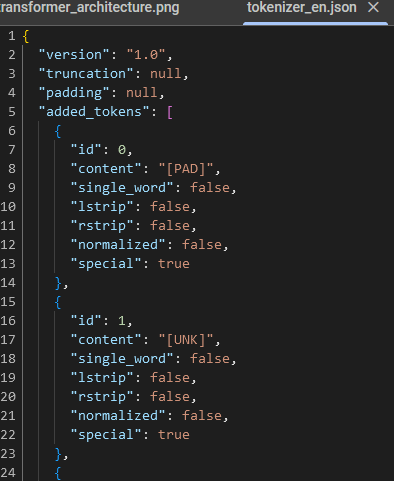

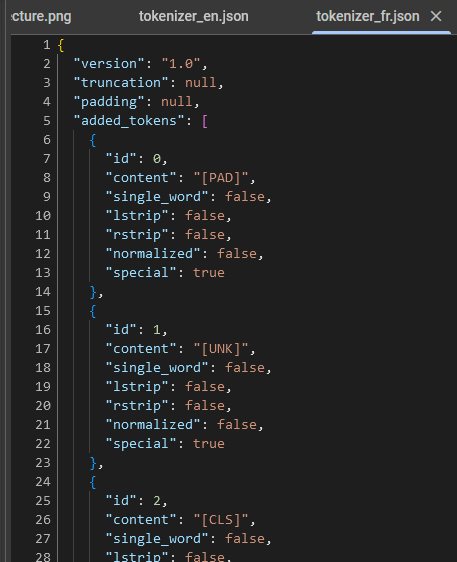

**Recupération des fichiers de tokenization origine**

In [ ]:
tokenizer_en = Tokenizer.from_file(repwil+"/tokenizer_en/tokenizer_en.json")
tokenizer_fr = Tokenizer.from_file(repwil+"/tokenizer_fr/tokenizer_fr.json")

In [ ]:
tokenizer_fr.get_vocab



<function Tokenizer.get_vocab(self, with_added_tokens=True)>

In [ ]:
source_vocab_size = tokenizer_en.get_vocab_size()
target_vocab_size = tokenizer_fr.get_vocab_size()
print(f'source_vocab_size eng: {source_vocab_size}')
print(f'target_vocab_size fr: {target_vocab_size}')
# la fonction get_vocab_size donne le nombre de token for the vocabulary

source_vocab_size eng: 4832
target_vocab_size fr: 5201


In [ ]:
raw_train_dataset[810]['translation']['fr']

"Le SCIT plénier a aussi convenu d'examiner ultérieurement la question de la durée des réunions des groupes de travail (une semaine), compte tenu de la charge de travail de ces derniers et des incidences financières; b) pour favoriser la participation de délégations des pays en développement et de certains pays d'Europe et d'Asie, l'OMPI devra inviter à ses frais, dans la limite des ressources financières disponibles, ces pays à participer aux sessions du SCIT plénier et de ses groupes de travail; c) le SCIT s'occupera non seulement des questions relatives au réseau mondial d'information, mais aussi d'autres questions relatives aux techniques de l'information qui se révéleront pertinentes pour les offices de propriété intellectuelle; d) l'adoption du projet de rapport par communication électronique après la réunion sera expérimentée pour la première session des groupes de travail en novembre 1998; le SCIT plénier a demandé au Secrétariat de mettre en place les installations nécessaires

In [ ]:
raw_train_dataset[810]['translation']['en']

'The Plenary also agreed to review the duration of the Working Groups (one week) in the future, taking into account their workload and financial considerations; (b) to assist the participation of delegations from developing countries and certain countries in Europe and Asia, subject to the availability of financial resources of WIPO, WIPO should invite at the expense of WIPO those delegations to participate in both the Plenary and Working Groups; (c) the SCIT should not only deal with matters concerning the global information network, but also with other matters concerning information technologies useful to intellectual property offices; (d) that the adoption of the draft report by electronic communication after the meeting be tested for the first meeting of the Working Groups in November 1998; the Plenary requested the Secretariat to install the necessary facilities to achieve this and report the result of the trial to the second session of the Plenary to assess it for further action 

In [ ]:
tokenizer_en.encode(raw_train_dataset[810]['translation']['en']).ids


[194,
 1734,
 439,
 2856,
 141,
 1103,
 127,
 4613,
 137,
 127,
 1716,
 3118,
 12,
 261,
 2065,
 13,
 125,
 127,
 1250,
 16,
 1039,
 600,
 954,
 382,
 372,
 174,
 167,
 144,
 922,
 978,
 257,
 31,
 12,
 67,
 13,
 141,
 746,
 127,
 2454,
 137,
 3114,
 263,
 2423,
 975,
 144,
 1137,
 975,
 125,
 466,
 144,
 429,
 413,
 16,
 1696,
 141,
 127,
 4287,
 137,
 922,
 3864,
 137,
 1805,
 16,
 1805,
 457,
 4074,
 130,
 127,
 223,
 1004,
 161,
 137,
 1805,
 560,
 3114,
 141,
 3075,
 125,
 1233,
 127,
 1734,
 144,
 1716,
 3118,
 31,
 12,
 68,
 13,
 127,
 4449,
 457,
 244,
 486,
 2862,
 195,
 2037,
 1727,
 127,
 2192,
 625,
 1419,
 16,
 431,
 439,
 195,
 355,
 2037,
 1727,
 625,
 3193,
 1347,
 141,
 545,
 77,
 2389,
 498,
 3216,
 1440,
 136,
 31,
 12,
 69,
 13,
 170,
 127,
 2460,
 137,
 127,
 1041,
 476,
 220,
 2095,
 4473,
 521,
 127,
 1050,
 160,
 2729,
 157,
 127,
 662,
 1050,
 137,
 127,
 1716,
 3118,
 125,
 1037,
 4158,
 31,
 127,
 1734,
 1499,
 127,
 2035,
 141,
 3125,
 127,
 1059,
 2436,
 14

In [ ]:
len(tokenizer_en.encode(raw_train_dataset[810]['translation']['en']).ids)

286

In [ ]:
for item in tokenizer_en.encode(raw_train_dataset[810]['translation']['en']).ids:
  print(tokenizer_en.id_to_token(item))
  print(item)
  print('------ ')

The
194
------ 
Plenary
1734
------ 
also
439
------ 
agreed
2856
------ 
to
141
------ 
review
1103
------ 
the
127
------ 
duration
4613
------ 
of
137
------ 
the
127
------ 
Working
1716
------ 
Groups
3118
------ 
(
12
------ 
one
261
------ 
week
2065
------ 
)
13
------ 
in
125
------ 
the
127
------ 
future
1250
------ 
,
16
------ 
taking
1039
------ 
into
600
------ 
account
954
------ 
their
382
------ 
work
372
------ 
lo
174
------ 
ad
167
------ 
and
144
------ 
financial
922
------ 
consider
978
------ 
ations
257
------ 
;
31
------ 
(
12
------ 
b
67
------ 
)
13
------ 
to
141
------ 
assist
746
------ 
the
127
------ 
participation
2454
------ 
of
137
------ 
delegations
3114
------ 
from
263
------ 
developing
2423
------ 
countries
975
------ 
and
144
------ 
certain
1137
------ 
countries
975
------ 
in
125
------ 
Europe
466
------ 
and
144
------ 
As
429
------ 
ia
413
------ 
,
16
------ 
subject
1696
------ 
to
141
------ 
the
127
------ 
availability
4287
---

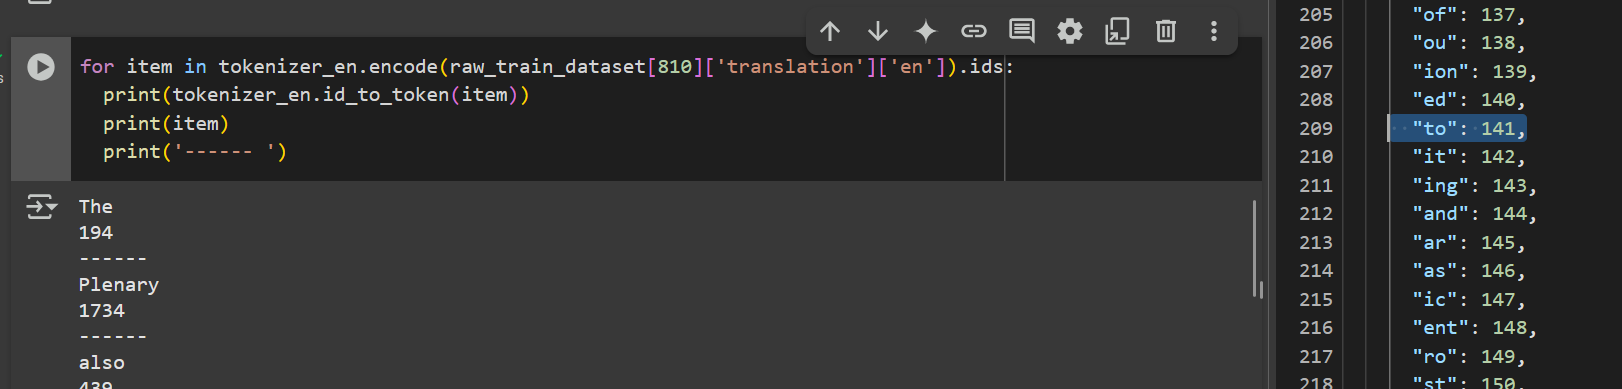

The Plenary also agreed to review the duration....



---



---



---



In [ ]:
# to calculate the max sequence lentgh in the entire training dataset for the source and target dataset
max_seq_len_source = 0
max_seq_len_target = 0
max_en=0
max_fr=0
for data in raw_train_dataset:
    enc_ids = tokenizer_en.encode(data['translation']['en']).ids
    dec_ids = tokenizer_fr.encode(data['translation']['fr']).ids
    max_seq_len_source = max(max_seq_len_source, len(enc_ids))
    max_seq_len_target = max(max_seq_len_target, len(dec_ids))

    if  len(enc_ids) > max_en :
      longest_token_gb= enc_ids
      longest_sentence_gb= data['translation']['en']
    if len(dec_ids) > max_fr :
      longest_token_fr= dec_ids
      longest_sentence_fr= data['translation']['fr']



print(" token longueur********************")
print(f'max_seqlen_source: {max_seq_len_source}')
print(f'max_seqlen_target: {max_seq_len_target}')

print(" anglais longueur********************")
print(f'longest_token_gb: {longest_token_gb}')
print(f'longest_sentence_gb: {longest_sentence_gb}')
print(f' longueur de la phrase initiale    : {len(longest_sentence_gb)}')
print(f'nb de token a la fin: {len(longest_token_gb)}')

print(" français longueur********************")
print(f'longest_token_fr: {longest_token_fr}')
print(f'longest_sentence_gb: {longest_sentence_fr}')
print(f' longueur de la phrase initiale    : {len(longest_sentence_fr)}')
print(f'nb de token a la fin:: {len(longest_token_fr)}')

 token longueur********************
max_seqlen_source: 286
max_seqlen_target: 417
 anglais longueur********************
longest_token_gb: [12, 86, 13, 194, 1092, 16, 2533, 134, 2222, 144, 1358, 137, 261, 133, 357, 1440, 246, 133, 2033, 137, 127, 164, 524, 143, 3742, 418, 186, 4360, 141, 1672, 202, 1143, 195, 144, 141, 2458, 3162, 1143, 263, 4335, 133, 3159, 125, 4642, 195, 127, 2823, 2104, 16, 1214, 127, 472, 1297, 137, 128, 4808, 31]
longest_sentence_gb: (u) The name, functional title and address of one or more officers or employees of the procuring entity who are authorized to communicate directly with and to receive communications directly from suppliers or contractors in connection with the procurement proceedings, without the intervention of an intermediary;
 longueur de la phrase initiale    : 313
nb de token a la fin: 57
 français longueur********************
longest_token_fr: [87, 13, 286, 438, 16, 154, 1534, 1046, 1402, 163, 78, 11, 4181, 178, 70, 11, 169, 153, 1301, 4708, 153

En général, non, les espaces eux-mêmes ne sont pas tokenisés comme des tokens distincts. Cependant, leur présence ou leur absence a un impact significatif sur la façon dont les autres caractères sont tokenisés

In [ ]:
# to calculate the max sequence lentgh in the entire training dataset for the source and target dataset
# max_seq_len_source = 0
# max_seq_len_target = 0
# max_en=0
# max_fr=0
# for data in raw_train_dataset:
#     enc_ids = tokenizer_en.encode(data['translation']['en']).ids
#     dec_ids = tokenizer_fr.encode(data['translation']['fr']).ids
#     max_seq_len_source = max(max_seq_len_source, len(enc_ids))
#     max_seq_len_target = max(max_seq_len_target, len(dec_ids))

#     if  len(enc_ids) > max_en :
#       longest_token_gb= enc_ids
#       longest_sentence_gb= data['translation']['en']
#     if len(dec_ids) > max_fr :
#       longest_token_fr= dec_ids
#       longest_sentence_fr= data['translation']['fr']




# print(f'max_seqlen_source: {max_seq_len_source}')   #99 - can be different in your case
# print(f'max_seqlen_target: {max_seq_len_target}')   #109 - can be different in your case
# print(f'longest_token_gb: {longest_token_gb}')
# print(f'longest_sentence_gb: {longest_sentence_gb}')
# print(f'longest_token_fr: {longest_token_fr}')



# print(f'longest_token_fr: {longest_token_fr}')
# print(f'longest_sentence_fr: {longest_sentence_fr}')


max_seqlen_source: 599
max_seqlen_target: 369
longest_token_gb: [196, 1020, 141, 3956, 2503, 137, 788, 143, 1035, 1138, 132, 310, 18]
longest_sentence_gb: The group of experts decides how to organize the work.
longest_token_fr: [292, 1232, 72, 11, 2178, 2406, 159, 159, 169, 2155, 992, 189, 785, 1547, 344, 2034, 18]
longest_token_fr: [292, 1232, 72, 11, 2178, 2406, 159, 159, 169, 2155, 992, 189, 785, 1547, 344, 2034, 18]
longest_sentence_fr: Le groupe d'experts décide de la manière dont il organise ses travaux.


In [ ]:
# to make it standard for our training we'll just take max_seq_len_source and add 150 to cover the additional tokens such as PAD, CLS, SEP
max_seq_len =  max(max_seq_len_source,max_seq_len_target )+150
max_seq_len

567

Cependant, vous avez raison de penser qu'on pourrait choisir une valeur plus proche des longueurs maximales observées. Prendre 120 comme max_seq_len serait tout à fait raisonnable et pourrait même être préférable dans certains cas



---



Step 3: Prepare Dataset and DataLoader

In [ ]:
# Step3: Prepare dataset and dataloader

# Transform raw dataset to the encoded dataset that can be processed by the model
class EncodeDataset(Dataset):
    def __init__(self, raw_dataset, max_seq_len):
        super().__init__()
        self.raw_dataset = raw_dataset
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, index):

        # fetching the single data for the given index value that consist of both english and french language.
        raw_text = self.raw_dataset[index]

        # separating text by source and target lanaguage which will be later used for encoding.
        source_text = raw_text['translation']['en']
        target_text = raw_text['translation']['fr']

        # Encoding source text with with english tokenizer and target text with french tokenizer
        source_text_encoded = tokenizer_en.encode(source_text).ids
        target_text_encoded = tokenizer_fr.encode(target_text).ids

        # Convert the CLS, SEP and PAD tokens to their corresponding index id in vocabulary using tokenizer [the id would be same with either tokenizers]
        CLS_ID = torch.tensor([tokenizer_en.token_to_id("[CLS]")], dtype=torch.int64)
        SEP_ID = torch.tensor([tokenizer_en.token_to_id("[SEP]")], dtype=torch.int64)
        PAD_ID = torch.tensor([tokenizer_en.token_to_id("[PAD]")], dtype=torch.int64)

        # To train the model, the sequence length of each input should be equal max seq length.
        #  Hence additional number of padding will be added to the input sequence if the length is not equal to the max seq length.
        num_source_padding = self.max_seq_len - len(source_text_encoded) - 2 #rajoute cls et sep
        num_target_padding = self.max_seq_len - len(target_text_encoded) - 1 #rajoute cls
        encoder_padding = torch.tensor([PAD_ID] * num_source_padding, dtype = torch.int64)
        decoder_padding = torch.tensor([PAD_ID] * num_target_padding, dtype = torch.int64)

        # encoder_input has the first token as start of senstence - CLS_ID, followed by source encoding which is then followed by the end of sentence token - SEP.
        # To reach the required max_seq_len, addition PAD token will be added at the end.
        encoder_input = torch.cat([CLS_ID, torch.tensor(source_text_encoded, dtype=torch.int64), SEP_ID, encoder_padding], dim=0)

        # decoder_input has the first token as start of senstence - CLS_ID, followed by target encoding.
        # To reach the required max_seq_len, addition PAD token will be added at the end. There is no end of sentence token - SEP in decoder input.
        decoder_input = torch.cat([CLS_ID, torch.tensor(target_text_encoded, dtype=torch.int64), decoder_padding ], dim=0)

        # target_label is required for the loss calculation during training to compare between the predicted and target label.
        # target_label has the first token as target encoding followed by actual target encoding. There is no start of sentence token - CLS in target label.
        # To reach the required max_seq_len, addition PAD token will be added at the end.
        target_label = torch.cat([torch.tensor(target_text_encoded, dtype=torch.int64),SEP_ID,decoder_padding], dim=0)

        # Since we've added extra padding token with input encoding, we don't want this token to be trained by model.
        # So, we'll use encoder mask to nullify the padding value prior to producing output of self attention in encoder block
        encoder_mask = (encoder_input != PAD_ID).unsqueeze(0).unsqueeze(0).int()
        # Si encoder_input est [2, 3, 4, 0, 0] (où 0 est PAD_ID), alors encoder_mask sera [[[1, 1, 1, 0, 0]]].

        # We don't want any token to get influence the future token during the decoding stage. Hence, Causal mask is being implemented during masked multihead attention to handle this.
        decoder_mask = (decoder_input != PAD_ID).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0))

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'target_label': target_label,
            'encoder_mask': encoder_mask,
            'decoder_mask': decoder_mask,
            'source_text': source_text,
            'target_text': target_text
        }


Cette ligne de code crée le masque pour le décodeur, qui est plus complexe que celui de l'encodeur car il combine deux types de masquage
decoder_mask = (decoder_input != PAD_ID).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0))

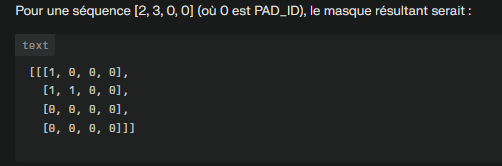

In [ ]:

# Causal mask will make sure any token that comes after the current token will be masked meaning
# the value will be replaced by -infinity that will be converted to zero or neearly zero
#  after softmax operation. Hence the model will just ignore these value or willn't be able to learn anything.
def causal_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0


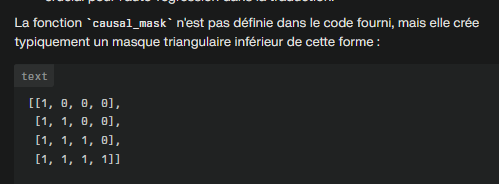

In [ ]:

# create a dataloader to use for model training and validation
train_ds = EncodeDataset(raw_train_dataset, max_seq_len)
val_ds = EncodeDataset(raw_validation_dataset, max_seq_len)

train_dataloader = DataLoader(train_ds, batch_size = 5, shuffle = True)
val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

Importance des DataLoaders

    Batching : Ils regroupent les données en lots, permettant un traitement parallèle efficace.
    Shuffling : Le mélange des données aide à réduire les biais et améliore la généralisation du modèle.
    Itération efficace : Ils gèrent efficacement le chargement des données, optimisant l'utilisation de la mémoire.
    Prétraitement automatique : Ils appliquent automatiquement les transformations définies dans EncodeDataset.




---



---



Step 4: Input Embedding and Positional Encoding

Input Embedding: The sequence of token IDs generated from tokenizers in step 2 will be fed into the embedding layer. The embedding layer maps the token-id to vocabulary and generates an embedding vector of dimension 512 for each token. [Dimension 512 is taken from the attention paper ]. The embedding vector can capture the semantic meaning of the token based on the training dataset it has been trained on. **Each dimension value inside the embedding vector represents some kind of feature related to the token. For example, if the token is a Dog, some dimension value would represent eyes, mouth, leg, height, etc. If we draw a vector in n-dimensional space, similar-looking objects such as dogs, and cats would be located near to each other,** and non-similar-looking objects such as schools, and home embedding vectors would be located much farther away.

Positional Encoding: One of the advantages of transformer architecture is that it can process any number of input sequences in parallel which reduces a lot of training time and also makes prediction much faster. However, one drawback is that while processing many sequences of tokens in parallel, the position of tokens in a sentence will not be in order. This could potentially result in different meanings or contexts of sentences depending on where the tokens are positioned. Hence, to resolve this issue, the attention paper implements the Positional Encoding method. The paper has suggested applying two mathematical functions (one is sin and one is cosine) on an index level of each token's 512 dimensions. Below is the simple sin and cosine mathematical function.

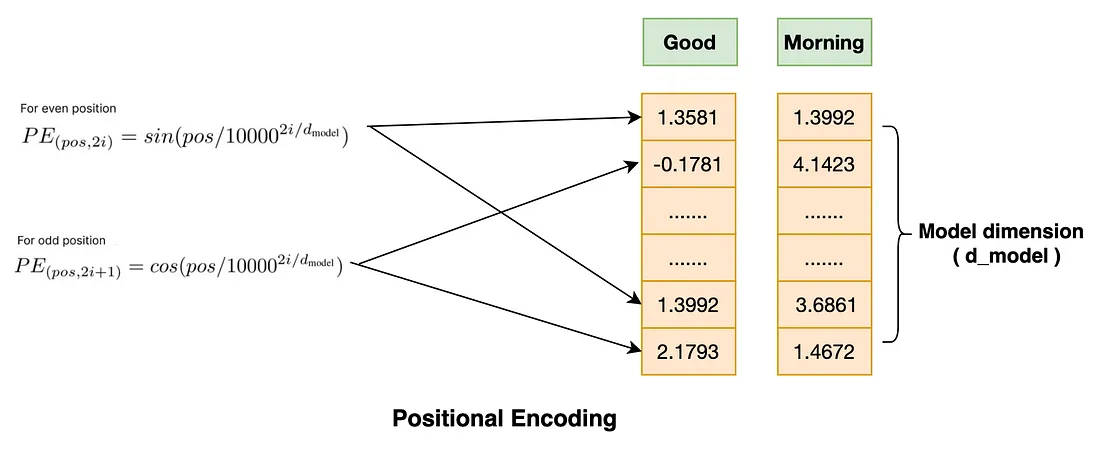

The sin function is applied to each even dimension value whereas the Cosine function is applied to the odd dimension value of the embedding vector. Finally, the resulting positional encoder vector will be added to the embedding vector. Now, we have the embedding vector which can capture the semantic meaning of the tokens as well as the position of the tokens. Please take note that the value of position encoding remains the same in every sequence.

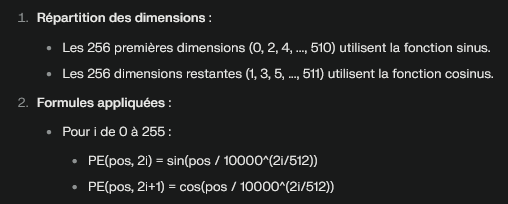

Input embedding and positional encoding

In [ ]:
# Step 4: Input embedding and positional encoding
import torch
import torch.nn as nn
import math

class EmbeddingLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        # using pytorch models embedding layer to map token id to embeeding vector which has the shape of (vocab_size, d_model)
        # The vocab_size is the vocabulary size of the training data created by tokenizer in step 2
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input):
        # In addition of giving input to the embedding, the extra multiplication by square root of d_model is to normalize the embedding layer output
        embedding_output = self.embedding(input) * math.sqrt(self.d_model)
        return embedding_output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_len: int, dropout_rate: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        pe = torch.zeros(max_seq_len, d_model)

        pos = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        # since we're expecting the input sentenses in batches so the extra dimension to cater batch number needs to be added in 0 postion
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, input_embdding):
        input_embdding = input_embdding + (self.pe[:, :input_embdding.shape[1], :]).requires_grad_(False)   # to prevent from calculating gradient
        return self.dropout(input_embdding)

on préfère l'approche sinusoïdale :

    Limitation de la magnitude : Un coefficient multiplicateur simple pourrait conduire à des valeurs très grandes pour les positions éloignées, ce qui pourrait déstabiliser le réseau.
    Périodicité : Les fonctions sinus et cosinus sont périodiques, ce qui permet au modèle de généraliser à des séquences plus longues que celles vues pendant l'entraînement.
    Information relative : L'encodage sinusoïdal permet au modèle de facilement calculer des relations relatives entre positions, quelle que soit leur distance absolue.
    Stabilité numérique : Les valeurs restent bornées entre -1 et 1, ce qui est bénéfique pour la stabilité numérique du réseau.
    Différentes fréquences : L'utilisation de différentes fréquences permet de capturer des dépendances à court et à long terme.
    Absence de paramètres supplémentaires : Contrairement à certaines autres méthodes, celle-ci ne nécessite pas d'apprentissage de paramètres supplémentaires.

En résumé, bien qu'un coefficient multiplicateur puisse sembler plus simple, l'encodage sinusoïdal offre une richesse d'information et des propriétés mathématiques qui s'avèrent très utiles pour les modèles Transformer.




---



---



Step 5: Multi-Head Attention Bloc

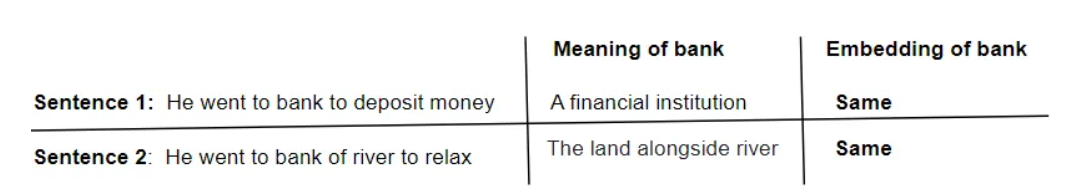

In sentence 1 and sentence 2, the word “bank ” clearly has two different meanings. However, the embedding value of the word “bank ” is the same in both sentences. This is not the right thing. **We want the embedding value to be changed based on the context of the sentence**. Hence, we need a mechanism where the embedding value can dynamically change to give the contextual meaning based on the overall meaning of the sentence. Self-attention mechanism can dynamically update the value of embedding that can represent the contextual meaning based on the sentence.

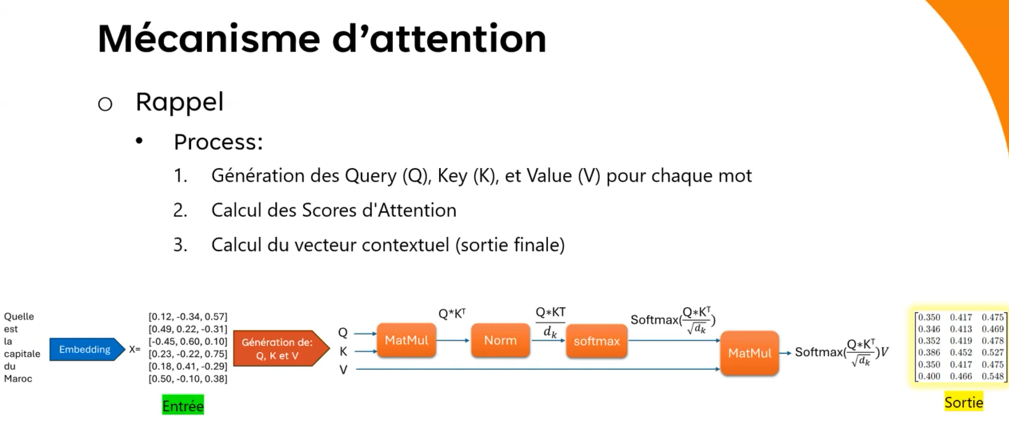

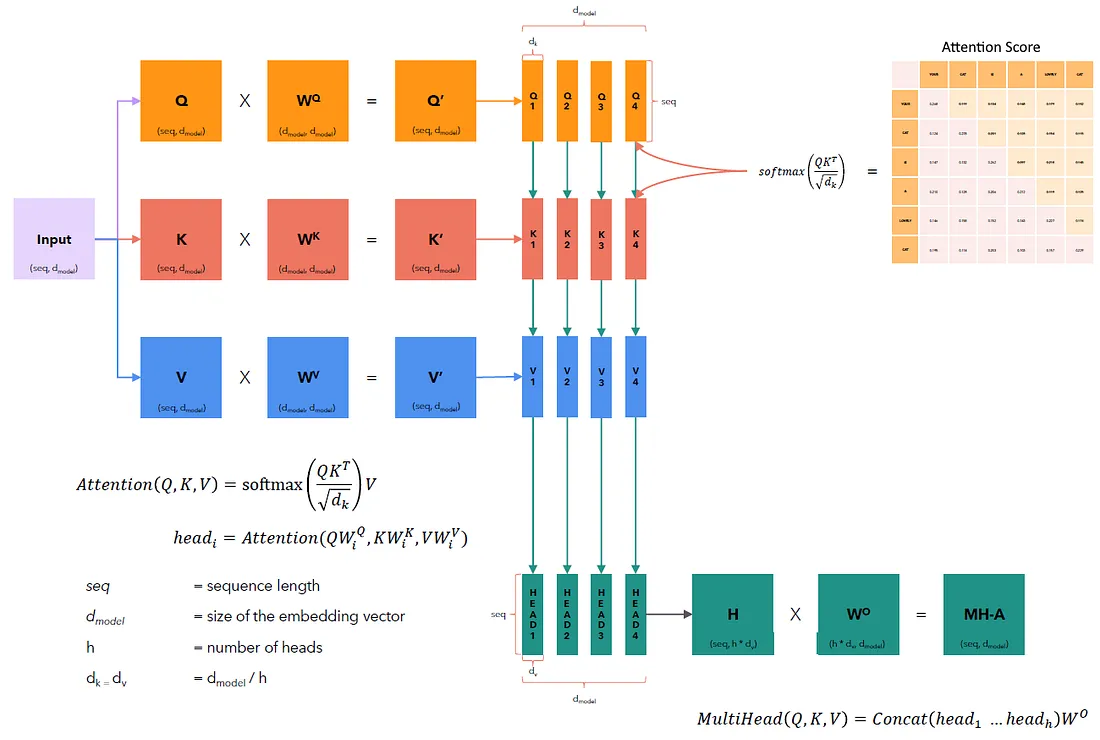

la matrice MH-A (Multi-Head Attention) représente bien différentes interactions possibles entre les tokens dans différents espaces, grâce aux différentes têtes et à la combinaison effectuée par WO. C'est une représentation riche qui capture de nombreuses nuances de la relation entre les éléments de la séquence



    La matrice d'attention est en fait softmax((Q @ K.T) / √d_k) @ V, où :
        Q = embedded_sentence @ W_q
        K = embedded_sentence @ W_k
        V = embedded_sentence @ W_v
    Cette opération peut être interprétée comme une représentation des relations entre les tokens dans un certain espace :
        Q @ K.T calcule les similarités entre les requêtes et les clés.
        Le softmax normalise ces similarités en scores d'attention.
        La multiplication par V pondère les valeurs selon ces scores d'attention.
    Chaque tête d'attention projette les embeddings dans un sous-espace différent :
        W_q, W_k, et W_v sont différents pour chaque tête.
        Cela permet au modèle d'apprendre différentes relations entre les tokens.
    Le résultat final est une nouvelle représentation de chaque token, qui prend en compte son contexte dans la séquence.

Donc, on peux dire que c'est une représentation des vecteurs d'embedding dans un espace, mais plus précisément, c'est une représentation qui capture les relations contextuelles entre ces vecteurs dans plusieurs sous-espaces différents (un pour chaque tête d'attention).

Creation de l'attention

In [ ]:
# Step 5: Multihead Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_rate: float):
        super().__init__()
        # Defining dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
        self.num_heads = num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by number of heads"



        # d_k is the new dimension of each self attention heads
        # d_model est la taille de l'embedding
        self.d_k = d_model // num_heads

        # Weight matrix are defined which are all learnable parameters
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, q, k, v, encoder_mask):

        # Please note that we'll be training our model with not just a single sequence but rather batches of sequence, hence we'll include batch_size in the shape
        # query, Key and value are calculated by matrix multiplication of corresponding weights with the input embeddings
        # Change of shape: q(batch_size, seq_len, d_model) @ W_q(d_model, d_model) => query(batch_size, seq_len, d_model) [same goes to key and value]
        query = self.W_q(q)
        key = self.W_k(k)
        value = self.W_v(v)

        # Dividing query, key and value into number of heads, hence new dimenstion will be d_k.
        # Change of shape: query(batch_size, seq_len, d_model) => query(batch_size, seq_len, num_heads, d_k) -> query(batch_size,num_heads, seq_len,d_k) [same goes to key and value]
        query = query.view(query.shape[0], query.shape[1], self.num_heads ,self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.num_heads ,self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.num_heads ,self.d_k).transpose(1,2)

        #d_mmodel sera divise en num_heads * d_k


                # Chaque token est toujours représenté par un vecteur complet de dimension d_model.

                # La division en têtes ne fragmente pas les tokens eux-mêmes, mais plutôt l'espace de représentation.


        # :: SELF ATTENTION BLOCK STARTS ::

        # Attention score is calculated to find the similarity or relation of query with key of itself and all other embedding in the sequence
        #  Change of shape: query(batch_size,num_heads, seq_len,d_k) @ key(batch_size,num_heads, seq_len,d_k) => attention_score(batch_size,num_heads, seq_len,seq_len)
        attention_score = (query @ key.transpose(-2,-1))/math.sqrt(self.d_k)

        # L'opération attention_score = (query @ key.transpose(-2,-1))/math.sqrt(self.d_k)
        #  effectue un calcul simultané sur toutes les têtes d'attention grâce à la manière dont les tenseurs sont structurés après le redimensionnement et la transposition.

        # If mask is provided the attention score needs to modify as per the mask value. Refer to the details in point no 4.
        if encoder_mask is not None:
          attention_score.masked_fill_(encoder_mask==0, -1e9)

        # Softmax operation calculates the probability distribution among all the attention scores. This will determine which embedding is more similar to the given query embedding and assign the attention weight accordingly.
        # Change of shape: same as attention_score
        attention_score = attention_score.softmax(dim=-1)

        if self.dropout is not None:
          attention_score = self.dropout(attention_score)

        # Final step of Self attention block is to matrix multiplication of attention_weight with value embedding.
        # Change of shape: attention_score(batch_size,num_heads, seq_len,seq_len) @  value(batch_size,num_heads, seq_len,d_k) => attention_output(batch_size,num_heads, seq_len,d_k)
        attention_output = attention_score @ value

        # :: SELF ATTENTION BLOCK ENDS ::

        # Now, all the heads will be concated back to for a single head
        # Change of shape:attention_output(batch_size,num_heads, seq_len,d_k) => attention_output(batch_size,seq_len,num_heads,d_k) => attention_output(batch_size,seq_len,d_model)
        attention_output = attention_output.transpose(1,2).contiguous().view(attention_output.shape[0], -1, self.num_heads * self.d_k)

        # Finally attention_output is matrix multiplied with output weight matrix to give the final Multi-Head attention output.
        # The shape of the multihead_output is same as the embedding input
        # Change of shape: attention_output(batch_size,seq_len,d_model) @ W_o(d_model, d_model) => multihead_output(batch_size, seq_len, d_model)
        multihead_output = self.W_o(attention_output)
        # output = attention_output @ self.W_o.weight.T
        # Cette opération est équivalente à une multiplication matricielle entre attention_output et la transposée de la matrice de poids de W_o.

        return multihead_output

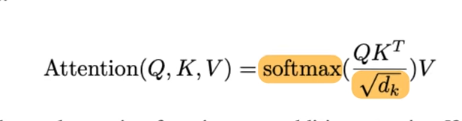

Step 6: Feedforward Network, Layer Normalization and AddAndNorm

Feedfoward Network: The feedfoward network uses a deep neural network to learn all the features of embedding vector across two linear layers (1st has d_model nodes and 2nd has d_ff nodes, value assigned as per the attention paper) and the ReLU activation function is applied to the output of 1st linear layer that provides non-linearity to the embeddings value and dropout is applied to further avoid overfitting.

LayerNorm: We apply layer normalization to the embedding value to ensure the distribution of value across the embedding vector in the network remains consistent. This ensures smooth learning. We’ll be using extra learning parameters called gamma and beta to scale and shift the embedding value as the network needs.

AddAndNorm: This consists of a skip connection and a layered normalization (explained earlier). During the forward pass, the Skip connection ensures that the features in the earlier layer can be still remembered in the later stage to make necessary contributions in calculating output. Similarly, during backward propagation, Skip connection ensures to prevention of vanishing gradient by needing to perform one less backpropagation in each stage. AddAndNorm is being used in both encoder(2 times) and decoder block (3 times). It takes input from the previous layer and normalizes it first before adding it to the output of the previous layer.

In [ ]:

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout_rate: float):
        super().__init__()

        self.dropout = nn.Dropout(dropout_rate)
        self.layer_1 = nn.Linear(d_model, d_ff)
        self.layer_2 = nn.Linear(d_ff, d_model)

    def forward(self, input):
        return self.layer_2(self.dropout(torch.relu(self.layer_1(input))))

class LayerNorm(nn.Module):
    # def __init__(self, features:int=512, eps: float = 1e-5):
    def __init__(self, eps: float = 1e-5):
        super().__init__()
        # epsilon is a very small value and is plays an important role to avoid division by zero problem
        self.eps = eps
        #Extra learning parameters gamma and beta are introduced to scale and shift the embedding value as the network needed.
        self.gamma = nn.Parameter(torch.ones(512))  # 512 = advisable to initialize with same number as d_model
        self.beta = nn.Parameter(torch.zeros(512))

    def forward(self, input):
        mean = input.mean(dim = -1, keepdim=True)
        std = input.std(dim = -1, keepdim=True)
        return self.gamma * (input - mean)/(std + self.eps) + self.beta

class AddAndNorm(nn.Module):
  def __init__(self, dropout_rate: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = LayerNorm()

  def forward(self, input, sub_layer):
        return input + self.dropout(sub_layer(self.layer_norm(input)))



---



Step 7: Encoder block and Encoder

Encoder Block: There are two main components inside the encoder block: Multi-Head Attention and Feedforward. There are also 2 units of Add & Norm. We’ll first assemble all these components in the EncoderBlock class as per the flow in the Attention paper. As per the paper, this encoder block has been **repeated 6 times.**

Encoder: We’ll then create an additional class called Encoder which will take the list of EncoderBlock stack it and give a final Encoder output.

In [ ]:
#Step 7: Encoder block and Encoder

class EncoderBlock(nn.Module):
    # def __init__(self, features: int, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout_rate: float) -> None:
    def __init__(self, multihead_attention: MultiHeadAttention, feed_forward: FeedForward, dropout_rate: float) -> None:
        super().__init__()
        self.multihead_attention = multihead_attention
        self.feed_forward = feed_forward
        self.addnorm_1 = AddAndNorm(dropout_rate)
        self.addnorm_2 = AddAndNorm(dropout_rate)

    def forward(self, encoder_input, encoder_mask):
        # First AddAndNorm unit taking encoder input from skip connection and adding it with the output of MultiHead attention block
        encoder_input = self.addnorm_1(encoder_input, lambda encoder_input: self.multihead_attention(encoder_input, encoder_input, encoder_input, encoder_mask))
        # Second AddAndNorm unit taking output of MultiHead attention block from skip connection and adding it with the output of Feedforward layer
        encoder_input = self.addnorm_2(encoder_input, self.feed_forward)
        return encoder_input

class Encoder(nn.Module):
    def __init__(self, encoderblocklist: nn.ModuleList) -> None:
        super().__init__()
        # Encoder class initialized by taking encoderblock list
        self.encoderblocklist = encoderblocklist
        self.layer_norm = LayerNorm()

    def forward(self, encoder_input, encoder_mask):
        # Looping through all the encoder block - 6 times
        for encoderblock in self.encoderblocklist:
            encoder_input = encoderblock(encoder_input, encoder_mask)
        # Normalize the final encoder block output and return. This encoder output will be used later on as key and value for the cross attention in decoder block
        encoder_output = self.layer_norm(encoder_input)
        return encoder_output

Step 8: Decoder block, Decoder and Projection Laye

Decoder Block: There are three main components in the Decoder block: Masked Multi-Head Attention, Multi-Head Attention, and Feedforward. The decoder block also has 3 units of Add & Norm. We’ll assemble all these components in the DecoderBlock class as per the flow in the Attention paper. As per the paper, this decoder block has been repeated 6 times.

Projection Layer: The final decoder output will be passed into the projection layer. In this layer, the decoder output will be first fed into a linear layer where the shape of the embedding will change as provided in the code section below. Subsequently, the softmax function converts the decoder output to the probability distribution over the vocabulary, and the token with the highest probability is selected as the prediction output.

In [ ]:
#Step 8: Decoder block and decoder and the projection

class DecoderBlock(nn.Module):
    # def __init__(self, features: int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout_rate: float) -> None:
    def __init__(self, masked_multihead_attention: MultiHeadAttention, cross_multihead_attention: MultiHeadAttention, feed_forward: FeedForward, dropout_rate: float) -> None:
        super().__init__()
        self.masked_multihead_attention = masked_multihead_attention
        self.cross_multihead_attention = cross_multihead_attention
        self.feed_forward = feed_forward
        self.addnorm_1 = AddAndNorm(dropout_rate)
        self.addnorm_2 = AddAndNorm(dropout_rate)
        self.addnorm_3 = AddAndNorm(dropout_rate)

    def forward(self, decoder_input, encoder_output, encoder_mask, decoder_mask):
        # First AddAndNorm unit taking decoder input from skip connection and adding it with the output of Masked Multi-Head attention block
        decoder_input = self.addnorm_1(decoder_input, lambda decoder_input: self.masked_multihead_attention(decoder_input, decoder_input, decoder_input, decoder_mask))
        # Second AddAndNorm unit taking output of Masked Multi-Head attention block from skip connection and adding it with the output of MultiHead attention block
        decoder_input = self.addnorm_2(decoder_input, lambda decoder_input: self.cross_multihead_attention(decoder_input, encoder_output, encoder_output, encoder_mask))
        # Third AddAndNorm unit taking output of MultiHead attention block from skip connection and adding it with the output of Feedforward layer
        decoder_input = self.addnorm_3(decoder_input, self.feed_forward)
        return decoder_input

class Decoder(nn.Module):
    # def __init__(self, features: int, layers: nn.ModuleList) -> None:
    def __init__(self, decoderblocklist: nn.ModuleList) -> None:
        super().__init__()
        self.decoderblocklist = decoderblocklist
        self.layer_norm = LayerNorm()

    def forward(self, decoder_input, encoder_output, encoder_mask, decoder_mask):
        for decoderblock in self.decoderblocklist:
            decoder_input = decoderblock(decoder_input, encoder_output, encoder_mask, decoder_mask)
        decoder_output = self.layer_norm(decoder_input)
        return decoder_output

class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.projection_layer = nn.Linear(d_model, vocab_size)

    def forward(self, decoder_output) -> None:
        # Projection layer first take in decoder output and feed into the linear layer of shape (d_model, vocab_size)
        #Change in shape: decoder_output(batch_size, seq_len, d_model) @ linear_layer(d_model, vocab_size) => output(batch_size, seq_len, vocab_size)
        output = self.projection_layer(decoder_output)
        return output



---



---



Step 9: Create and build a Transformer

Finally, we’ve completed building all the component blocks in the transformer architecture. The only pending task is to assemble it all together.

**First, we create a Transformer class which will initialize all the instances of component classes**. Inside the transformer class, we’ll first define encode function that does all the tasks in the encoder part of the transformer and generates the encoder output.

Second, we define a decode function that does all the tasks in the decoder part of the transformer and generates decoder output.

Third, we define a project function, which takes in the decoder output and maps the output to the vocabulary for prediction.

**Now, the transformer architecture is ready. We can now build our translation LLM Model, by defining a function that takes in all the necessary parameters as given in the code below.**

In [ ]:
#Step 9: Create and build Transfomer
class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, source_embed: EmbeddingLayer, target_embed: EmbeddingLayer, source_pos: PositionalEncoding, target_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()

        self.source_embed = source_embed
        self.source_pos = source_pos
        self.encoder = encoder

        self.target_embed = target_embed
        self.target_pos = target_pos
        self.decoder = decoder

        self.projection_layer = projection_layer

    def encode(self, encoder_input, encoder_mask):
        encoder_input = self.source_embed(encoder_input)
        encoder_input = self.source_pos(encoder_input)
        encoder_output = self.encoder(encoder_input, encoder_mask)
        return encoder_output

    def decode(self, encoder_output, encoder_mask, decoder_input, decoder_mask):
        decoder_input = self.target_embed(decoder_input)
        decoder_input = self.target_pos(decoder_input)
        decoder_output = self.decoder(decoder_input, encoder_output, encoder_mask, decoder_mask)
        return decoder_output

    def project(self, decoder_output):
        return self.projection_layer(decoder_output)

def build_model(source_vocab_size: int, target_vocab_size: int, source_seq_len: int, target_seq_len: int, d_model: int=512, num_blocks: int=6, num_heads: int=8, dropout_rate: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    source_embed = EmbeddingLayer(d_model, source_vocab_size)
    target_embed = EmbeddingLayer(d_model, target_vocab_size)

    # Create the positional encoding layers
    source_pos = PositionalEncoding(d_model, source_seq_len, dropout_rate)
    target_pos = PositionalEncoding(d_model, target_seq_len, dropout_rate)

    # Create the encoder-block-list
    encoderblocklist = []
    for _ in range(num_blocks):
        multihead_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        encoder_block = EncoderBlock(multihead_attention, feed_forward, dropout_rate)
        encoderblocklist.append(encoder_block)
    # Create the encoder
    encoder = Encoder(nn.ModuleList(encoderblocklist))

    # Create the decoder-block-list
    decoderblocklist = []
    for _ in range(num_blocks):
        masked_multihead_attention = MultiHeadAttention(d_model,num_heads, dropout_rate)
        cross_multihead_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        decoder_block = DecoderBlock(masked_multihead_attention, cross_multihead_attention, feed_forward, dropout_rate)
        decoderblocklist.append(decoder_block)
    # Create the decoder
    decoder = Decoder(nn.ModuleList(decoderblocklist))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, target_vocab_size)

    # Now that we've initialized all the required blocks of transformer, we can now inititiate a model
    model = Transformer(encoder, decoder, source_embed, target_embed, source_pos, target_pos, projection_layer)

    # For the first time, we'll initialize the model parameters using xavier uniform method. Once training begings the parameters will be updated by the network
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

# Let's build the the final model.
model = build_model(tokenizer_en.get_vocab_size(), tokenizer_fr.get_vocab_size(),max_seq_len, max_seq_len, d_model=512).to(device)

# Let's look at the architecture that we've just build ourself
print(model)

In [ ]:
from graphviz import Digraph

def create_transformer_graph():
    dot = Digraph(comment='Transformer Architecture')
    dot.attr(rankdir='TB', size='8,8')

    # Subgraphs
    with dot.subgraph(name='cluster_encoder') as c:
        c.attr(label='Encoder')
        c.node('source_embed', 'Source Embedding')
        c.node('source_pos', 'Source Positional Encoding')
        c.node('encoder', 'Encoder Blocks')

    with dot.subgraph(name='cluster_decoder') as c:
        c.attr(label='Decoder')
        c.node('target_embed', 'Target Embedding')
        c.node('target_pos', 'Target Positional Encoding')
        c.node('decoder', 'Decoder Blocks')

    dot.node('projection', 'Projection Layer')

    # Edges
    dot.edge('source_embed', 'source_pos')
    dot.edge('source_pos', 'encoder')
    dot.edge('target_embed', 'target_pos')
    dot.edge('target_pos', 'decoder')
    dot.edge('encoder', 'decoder')
    dot.edge('decoder', 'projection')

    return dot

# Create and render the graph
graph = create_transformer_graph()
graph.render('transformer_architecture', format='png', cleanup=True)
print("Graph has been rendered to 'transformer_architecture.png'")


Ce code montre que :

    L'encodeur ne s'exécute qu'une fois
    Le décodeur fonctionne de manière itérative
    La réinjection est explicitement gérée via la concaténation du nouveau token avec la séquence déjà générée
    Le processus continue jusqu'à atteindre la longueur maximale ou générer un token de fin

La réinjection n'est donc pas automatique, elle doit être implémentée dans la logique de génération.

In [ ]:
b

In [ ]:
def translate_simple(model, source_sentence="Hello world", max_length=50):
    # 1. Encoder la phrase source (une seule fois)
    encoder_output = model.encode(
        encoder_input=tokenizer_en.encode(source_sentence),
        encoder_mask=None
    )

    # 2. Initialiser le décodeur avec START
    decoder_input = torch.tensor([[tokenizer_fr.token_to_id("<START>")]])

    output_sequence = []

    # 3. Génération auto-régressive
    for _ in range(max_length):
        # Passer par le décodeur
        decoder_output = model.decode(
            encoder_output=encoder_output,
            decoder_input=decoder_input,
            encoder_mask=None,
            decoder_mask=None
        )

        # Obtenir les probabilités
        probabilities = model.project(decoder_output)

        # Sélectionner le meilleur token
        next_token = torch.argmax(probabilities[:, -1:], dim=-1)

        # Ajouter à la séquence de sortie
        token_id = next_token.item()
        output_sequence.append(token_id)

        # Réinjecter dans l'entrée du décodeur
        decoder_input = torch.cat([decoder_input, next_token], dim=1)

        # Arrêter si token de fin généré
        if token_id == tokenizer_fr.token_to_id("<END>"):
            break

    # 4. Convertir les IDs en tokens
    translated_tokens = tokenizer_fr.decode(output_sequence)
    return " ".join(translated_tokens)

# Utilisation
source_sentence = "Hello world"
translation = translate_simple(model, source_sentence)
print(f"Source: {source_sentence}")
print(f"Traduction: {translation}")


Appentissage d'un transformer



---



---



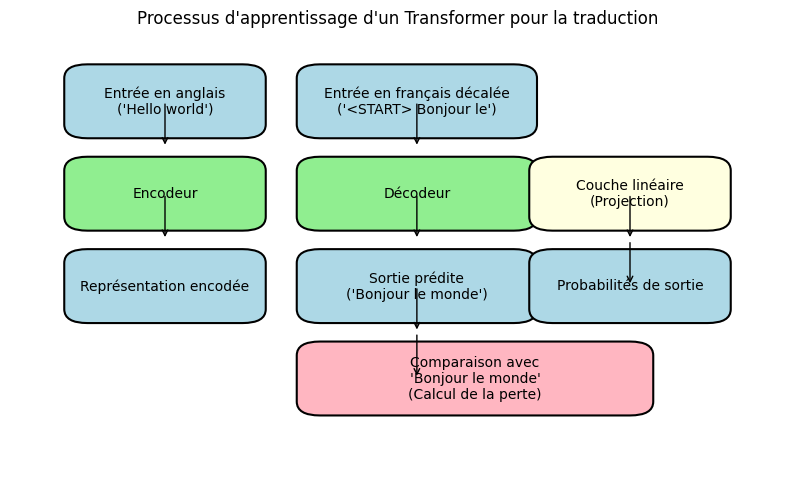

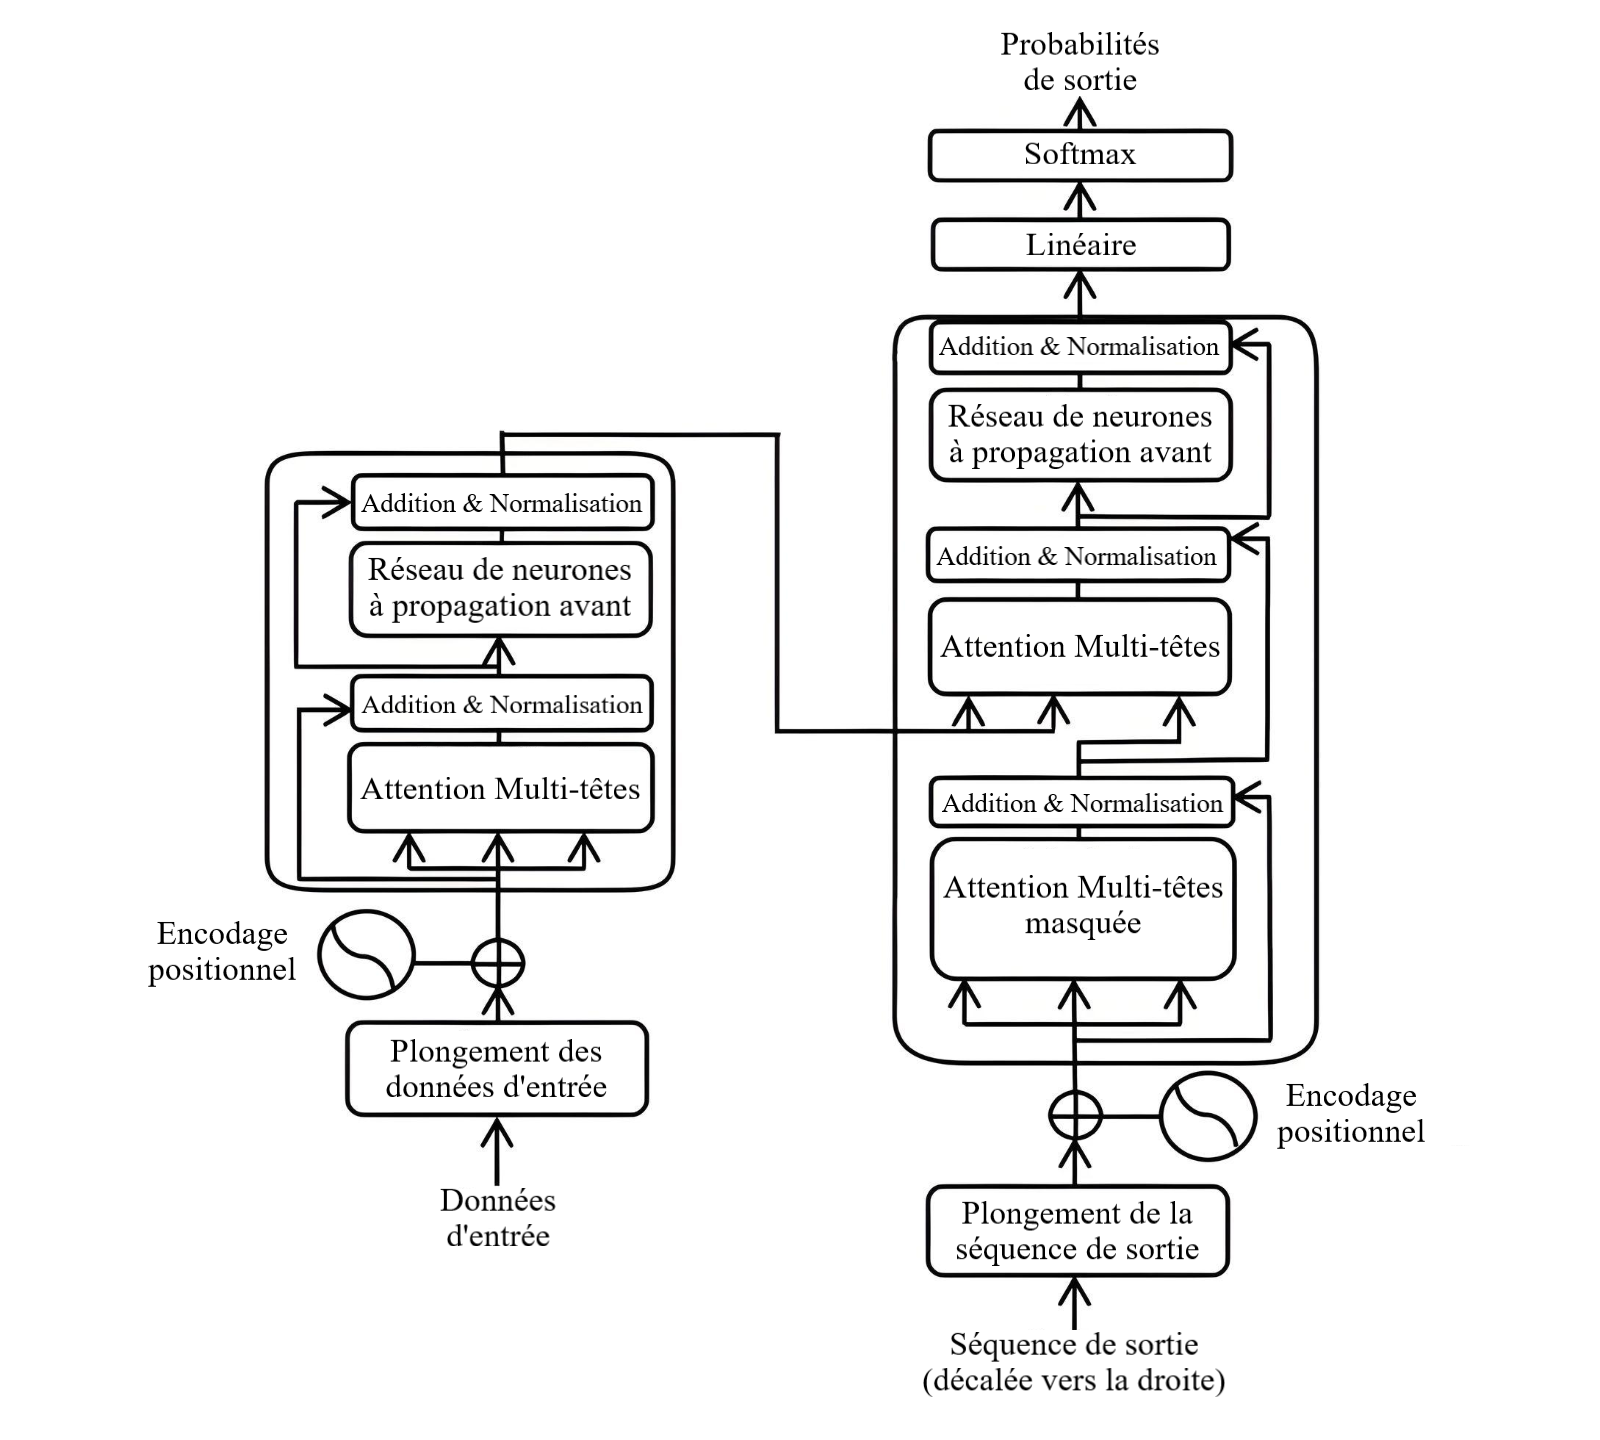

Step 10: Training and validation of our build LLM model

It is now the time to train our model. The training process is pretty straightforward. We are going to use the training DataLoader which we’ve created in step 3. As the total training dataset number is 1 million, I would highly recommend training our model on a GPU device. It took me around 5 hr to complete 20 epochs. After each epoch, we are going to save the model weights along with the optimizer state so that it would be easier to resume training from the point before it stopped rather than resume from the start.

After every epoch, we are going to initiate a validation using the validation DataLoader. The size of the validation dataset is 2000 which is pretty reasonable. During the validation process, we just need to calculate the encoder output once until the decoder output gets the end-of-sentence token [SEP], this is because until the decoder gets [SEP] token, we’ll have to send the same encoder output again, and again which doesn’t make sense.

The decoder input will first start with the start of the sentence token [CLS]. After each prediction, the decoder input will append the next generated token till the end of sentence token [SEP] is reached. Finally, the projection layer maps the output to the corresponding text representation.

In [ ]:
#Step 10: Training and Validation of frGPT

def run_validation(model, validation_ds, tokenizer_en, tokenizer_my, max_seq_len, device, print_msg, global_step):
    model.eval()
    count = 0

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)

            cls_id = tokenizer_my.token_to_id('[CLS]')
            sep_id = tokenizer_my.token_to_id('[SEP]')

            # Computing the output of the encoder for the source sequence
            encoder_output = model.encode(encoder_input, encoder_mask)
            # for prediction task, the first token that goes in decoder input is the [CLS] token
            decoder_input = torch.empty(1, 1).fill_(cls_id).type_as(encoder_input).to(device)
            # since we need to keep adding the output back to the input until the [SEP] - end token is received.
            while True:
                # check if the max length is received
                if decoder_input.size(1) == max_seq_len:
                    break

                # recreate mask each time the new output is added the decoder input for next token prediction
                decoder_mask = causal_mask(decoder_input.size(1)).type_as(encoder_mask).to(device)

                # apply projection only to the next token
                out = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)

                # apply projection only to the next token
                prob = model.project(out[:, -1])

                # select the token with highest probablity which is a greedy search implementation
                _, next_word = torch.max(prob, dim=1)
                decoder_input = torch.cat(
                    [decoder_input, torch.empty(1, 1).type_as(encoder_input).fill_(next_word.item()).to(device)], dim=1
                )
                # check if the new token is the end of token
                if next_word == sep_id:
                    break
            # final output is the concatinated decoder input till the end token is reached
            model_out = decoder_input.squeeze(0)

            source_text = batch["source_text"][0]
            target_text = batch["target_text"][0]
            model_out_text = tokenizer_my.decode(model_out.detach().cpu().numpy())

            # Print the source, target and model output
            print_msg('-'*55)
            # print_msg(f"{f'SOURCE: ':>12}{source_text}")
            # print_msg(f"{f'TARGET: ':>12}{target_text}")
            # print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")
            print_msg(f'Source Text: {source_text}')
            print_msg(f'Target Text: {target_text}')
            print_msg(f'Predicted by frGPT: {model_out_text}')

            if count == 2:
                break

def train_model(preload_epoch=None):
    # The entire training, validation cycle will run for 20 cycles or epochs.
    EPOCHS = 10
    initial_epoch = 0
    global_step = 0

    # Adam is one of the most commonly used optimization algorithms that hold the current state and will update the parameters based on the computed gradients.
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-9)

    # If the preload_epoch is not none, that means the training will start with the weights, optimizer that has been last saved and start with preload epoch + 1
    if preload_epoch is not None:
      model_filename = f"./frgpt/model_{preload_epoch}.pt"
      state = torch.load(model_filename)
      model.load_state_dict(state['model_state_dict'])
      initial_epoch = state['epoch'] + 1
      optimizer.load_state_dict(state['optimizer_state_dict'])
      global_step = state['global_step']

    # The CrossEntropyLoss loss function computes the difference between the projection output and target label.
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_en.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, EPOCHS):
        # torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:
            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)
            target_label = batch['target_label'].to(device) # (B, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            projection_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(projection_output.view(-1, tokenizer_my.get_vocab_size()), target_label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # VALIDATION BLOCK STARTS HERE [Runs every epoch after the training block is complete]
        run_validation(model, val_dataloader, tokenizer_en, tokenizer_my, max_seq_len, device, lambda msg: batch_iterator.write(msg), global_step)

        # Save the model at the end of every epoch
        model_filename = f"./frgpt/model_{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

# Train our model
train_model(preload_epoch=None)



---



---



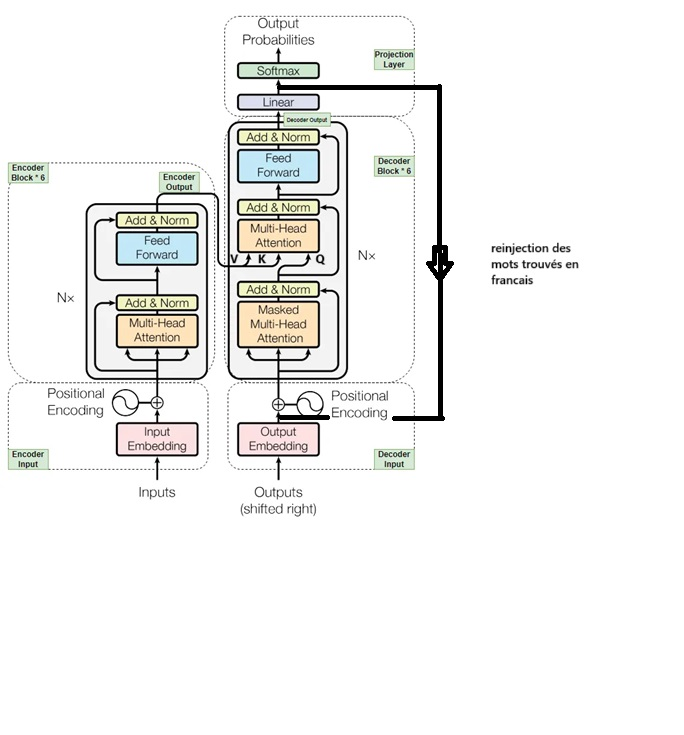